<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

# <center> Проект: Анализ вакансий из HeadHunter
   

# Импорт библиотек и создание подключения

In [1]:
import pandas as pd
import psycopg2
import requests # Импортируем библиотеку requests
from io import StringIO
from bs4 import BeautifulSoup

In [2]:
print(pd.__version__)

2.2.1


In [3]:
# Что избежать отображение предупреждений об использовании sqlalchemy 
import warnings
warnings.filterwarnings("ignore")

In [80]:
pip install html5lib

  Obtaining dependency information for html5lib from https://files.pythonhosted.org/packages/6c/dd/a834df6482147d48e225a49515aabc28974ad5a4ca3215c18a882565b028/html5lib-1.1-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/112.2 kB ? eta -:--:--
   --- ------------------------------------ 10.2/112.2 kB ? eta -:--:--
   -------------- ------------------------ 41.0/112.2 kB 393.8 kB/s eta 0:00:01
   --------------------- ----------------- 61.4/112.2 kB 409.6 kB/s eta 0:00:01
   ---------------------------------- --- 102.4/112.2 kB 587.0 kB/s eta 0:00:01
   -------------------------------------- 112.2/112.2 kB 542.2 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
# вставьте сюда параметры подключения из юнита 1. Работа с базой данных из Python 

In [4]:
# Прошу удалить параметры подключения к БД школы из общего доступа

DBNAME = 'project_sql'
USER = 'skillfactory'
PASSWORD = 'cCkxxLVrDE8EbvjueeMedPKt'
HOST = '84.201.134.129'
PORT = 5432

connection = psycopg2.connect(
    dbname=DBNAME,
    user=USER,
    host=HOST,
    password=PASSWORD,
    port=PORT
)

In [63]:
# Совсем непонятно зачем закрывать соединения, прямо после того, как мы его установили

# connection.close()

# Юнит 3. Предварительный анализ данных

1. Напишите запрос, который посчитает количество вакансий в нашей базе (вакансии находятся в таблице vacancies). 

In [5]:
# текст запроса
query_3_1 = f'''
                select count(*) count_all_vacancies 
                from public.vacancies
            '''

In [6]:
# результат запроса
pd.read_sql(query_3_1, connection)

,count_all_vacancies
0,49197


2. Напишите запрос, который посчитает количество работодателей (таблица employers). 

In [7]:
# текст запроса
query_3_2 = f'''
                select count(id) count_employers 
                from public.employers
            '''

In [8]:
# результат запроса
pd.read_sql(query_3_2, connection)

,count_employers
0,23501


3. Посчитате с помощью запроса количество регионов (таблица areas).

In [9]:
# текст запроса
query_3_3 = f'''
                select count(id) count_areas 
                from public.areas
            '''

In [10]:
# результат запроса
pd.read_sql(query_3_3, connection)

,count_areas
0,1362


In [11]:
query_areas = f'''
                select distinct id, name
                from public.areas
            '''

In [12]:
# результат запроса
pd.read_sql(query_areas, connection)

,id,name
0,6493,Аса
1,301,Обнинск
2,1410,Усть-Катав
3,9,Азербайджан
4,1483,Буденновск
...,...,...
1357,1861,Белоусово
1358,1637,Лениногорск
1359,1042,Воркута
1360,2265,Полоцк


4. Посчитате с помощью запроса количество сфер деятельности в базе (таблица industries).

In [13]:
# текст запроса
query_3_4 = f'''
                select count(id) count_industries 
                from public.industries
            '''

In [14]:
# результат запроса
pd.read_sql(query_3_4, connection)

,count_industries
0,294


***

Выводы по предварительному анализу данных:
1. Вакансий намного больше, чем работодателей. Скорее всего среди работадателей присутствуют большие компании
2. Регионов 1362, в то время как в России всего 89 регионов - значит, рассматриваются не только вакансии из России.

# Юнит 4. Детальный анализ вакансий

1. Напишите запрос, который позволит узнать, сколько (cnt) вакансий в каждом регионе (area).
Отсортируйте по количеству вакансий в порядке убывания.

In [15]:
# текст запроса
query_4_1 = f'''
                select ar.name, count(vac.name) count_areas 
                from public.areas ar join public.vacancies vac
                on ar.id = vac.area_id
                group by ar.name
                order by count_areas desc
            '''

In [16]:
# результат запроса
pd.read_sql(query_4_1, connection)

,name,count_areas
0,Москва,5333
1,Санкт-Петербург,2851
2,Минск,2112
3,Новосибирск,2006
4,Алматы,1892
...,...,...
764,Тарко-Сале,1
765,Новоаннинский,1
766,Бирск,1
767,Сасово,1


2. Напишите запрос, чтобы определить у какого количества вакансий заполнено хотя бы одно из двух полей с зарплатой.

In [17]:
# текст запроса
query_4_2 = f'''
                select count(vac.id) count_salaries 
                from public.vacancies vac
                where vac.salary_from is not null or vac.salary_to is not null
            '''

In [18]:
# результат запроса
pd.read_sql(query_4_2, connection)

,count_salaries
0,24073


Узнаем, сколько это в процентах от общего количества вакансий:

In [19]:
# доля вакансий с заполненной зарплатой, %
round(pd.read_sql(query_4_2, connection).count_salaries[0]/pd.read_sql(query_3_1, connection).count_all_vacancies[0]*100)

49

3. Найдите средние значения для нижней и верхней границы зарплатной вилки. Округлите значения до целого.

In [20]:
# текст запроса
query_4_3 = f'''
                select round(avg(vac.salary_from),0)::integer salary_from, round(avg(vac.salary_to),0)::integer salary_to
                from public.vacancies vac
            '''

In [21]:
# результат запроса
pd.read_sql(query_4_3, connection)

,salary_from,salary_to
0,71065,110537


4. Напишите запрос, который выведет количество вакансий для каждого сочетания типа рабочего графика (schedule) и типа трудоустройства (employment), используемого в вакансиях. Результат отсортируйте по убыванию количества.


In [22]:
# текст запроса
query_4_4 = f'''
                select vac.schedule, vac.employment, count(vac.id) cnt
                from public.vacancies vac
                group by vac.schedule, vac.employment
                order by cnt desc
            '''

In [23]:
# результат запроса
pd.read_sql(query_4_4, connection)

,schedule,employment,cnt
0,Полный день,Полная занятость,35367
1,Удаленная работа,Полная занятость,7802
2,Гибкий график,Полная занятость,1593
3,Удаленная работа,Частичная занятость,1312
4,Сменный график,Полная занятость,940
5,Полный день,Стажировка,569
6,Вахтовый метод,Полная занятость,367
7,Полный день,Частичная занятость,347
8,Гибкий график,Частичная занятость,312
9,Полный день,Проектная работа,141


5. Напишите запрос, выводящий значения поля Требуемый опыт работы (experience) в порядке возрастания количества вакансий, в которых указан данный вариант опыта. 

In [24]:
# текст запроса
query_4_5 = f'''
                select vac.experience
                from public.vacancies vac
                group by vac.experience
                order by count(vac.id) asc
            '''

In [25]:
# результат запроса
pd.read_sql(query_4_5, connection)

,experience
0,Более 6 лет
1,Нет опыта
2,От 3 до 6 лет
3,От 1 года до 3 лет


***

Выводы по детальному анализу вакансий:
1. Как и можно было ожидать, больше всего вакансий в Москве, Санкт-Петербурге и других крупных городах. Странно, что в городе Бирск с населением 44 тыс. человек всего одна вакансия.
2. Поле с зарплатой заполнено примерно в половине вакансий (49%). Это довольно много (согласно статье от 21-го года зарплаты не заполнены примерно в 25% вакансий https://hh.ru/article/23913)
3. Зарплатная вилка находится в пределах от 71065 до 110537 руб. В принципе это согласуется с данными Росстата о средней ЗП в РФ за 2023 год - 74854 руб. Но средняя ЗП очень близка к нижней границе зарплатной вилки. Думаю, это объясняется тем, что в списке немало иностранных регионов.
4. Все вакансии из топ-3 по числу вакансий предполагают тип трудоустройства - полную занятость. Количество вакансий с типом рабочего графика - "полный день работы" находится на 1-м месте и значительно превышает все другие. Типы рабочего графика "вахтовый метод" и "сменный график" очень редко сочитаются с типом трудоустройства "проектная работа".
5. Реже всего требуются сотрудники с опытом более 6 лет; чаще всего - с опытом от 1-го года до 3-х лет. Интересно, что сотрудники с опытом более 6 лет требуется даже реже чем сотрудники без опыта. Предполагаю, что это связано с трендом на постоянное обновление знаний - ценен не тот, кто знает определённый предмет досконально, а тот кто способен осваивать новое.

# Юнит 5. Анализ работодателей

1. Напишите запрос, который позволит узнать, какие работодатели находятся на первом и пятом месте по количеству вакансий.

In [26]:
# текст запроса
query_5_1 = f'''
                select empl.name, count(vac.id)
                from public.vacancies vac 
                left join public.employers empl
                on empl.id = vac.employer_id
                group by empl.name
                order by count(empl.id) desc
                limit 5
            '''

In [28]:
# результат запроса
pd.read_sql(query_5_1, connection)

,name,count
0,Яндекс,1933
1,Ростелеком,491
2,Тинькофф,444
3,СБЕР,428
4,Газпром нефть,331


2. Напишите запрос, который для каждого региона выведет количество работодателей и вакансий в нём.
Среди регионов, в которых нет вакансий, найдите тот, в котором наибольшее количество работодателей.


In [29]:
query_5_2 = f'''
                SELECT ar.name, COUNT(empl.id) as empl_cnt, COUNT(vac.id) as vac_cnt
                FROM
                areas ar 
                LEFT JOIN employers empl ON ar.id = empl.area 
                LEFT JOIN vacancies vac ON ar.id = vac.area_id
                GROUP BY ar.name
                HAVING COUNT(vac.id) = 0
                ORDER BY empl_cnt DESC
            '''

In [30]:
pd.read_sql(query_5_2, connection)

,name,empl_cnt,vac_cnt
0,Россия,410,0
1,Казахстан,207,0
2,Московская область,75,0
3,Краснодарский край,19,0
4,Ростовская область,18,0
...,...,...,...
588,Струнино,0,0
589,Славгород (Алтайский край),0,0
590,Сорочинск,0,0
591,Ленинский (Тульская область),0,0


3. Для каждого работодателя посчитайте количество регионов, в которых он публикует свои вакансии. Отсортируйте результат по убыванию количества.


In [31]:
# текст запроса

query_5_3 = f'''
                SELECT empl.name empl_name, COUNT(DISTINCT ar.id) cnt_ar_id
                FROM employers empl 
                LEFT JOIN vacancies vac ON  empl.id  =  vac.employer_id
                LEFT JOIN areas ar ON vac.area_id = ar.id
                GROUP BY empl_name
                ORDER BY  COUNT(ar.name) DESC
            '''

In [32]:
pd.read_sql(query_5_3, connection)

,empl_name,cnt_ar_id
0,Яндекс,181
1,Ростелеком,152
2,Тинькофф,43
3,СБЕР,24
4,Газпром нефть,24
...,...,...
23170,Независимое агентство Аналитика товарных рынков,0
23171,Независимое Информационное Агентство,0
23172,Независимое телевидение Севастополя,0
23173,Независимость,0


4. Напишите запрос для подсчёта количества работодателей, у которых не указана сфера деятельности. 

In [33]:
# текст запроса
query_5_4 = f'''
            SELECT COUNT(DISTINCT res.id)
            FROM
                (
                 SELECT e.id, ei.industry_id
                FROM employers e
                LEFT JOIN employers_industries ei ON e.id = ei.employer_id
                WHERE industry_id IS NULL
                ) res
            '''

In [34]:
# результат запроса
pd.read_sql(query_5_4, connection)

,count
0,8419


In [35]:
# Доля работодателей в %, у которых не указана сфера деятельности.
'Доля компаний без указания сферы деятельности: ' + str(round((pd.read_sql(query_5_4, connection)['count'][0]/pd.read_sql(query_3_2, connection).count_employers[0])*100)) + '%'

'Доля компаний без указания сферы деятельности: 36%'

5. Напишите запрос, чтобы узнать название компании, находящейся на третьем месте в алфавитном списке (по названию) компаний, у которых указано четыре сферы деятельности. 

In [36]:
# текст запроса
query_5_5 = f'''
            SELECT e.id, e.name, COUNT(ei.industry_id)
            FROM employers e
            LEFT JOIN employers_industries ei ON e.id = ei.employer_id
            GROUP BY e.id, e.name
            HAVING COUNT(ei.industry_id) = 4
            ORDER BY e.name
            OFFSET 2 LIMIT 1
            
            '''

In [37]:
# результат запроса
pd.read_sql(query_5_5, connection)

,id,name,count
0,64174,2ГИС,4


6. С помощью запроса выясните, у какого количества работодателей в качестве сферы деятельности указана Разработка программного обеспечения.


In [38]:
# текст запроса
query_5_6 = f'''
            SELECT COUNT(e.id) PO_cnt
            FROM employers e
            LEFT JOIN employers_industries ei ON e.id = ei.employer_id
            LEFT JOIN industries i ON i.id = ei.industry_id
            WHERE i.name = 'Разработка программного обеспечения'            
            '''

In [39]:
# результат запроса
pd.read_sql(query_5_6, connection)

,po_cnt
0,3553


In [40]:
# Доля количества работодателей в %, у которых в качестве сферы деятельности указана "Разработка программного обеспечения".
'Доля компаний в сфере разработки ПО: '+str(round((pd.read_sql(query_5_6, connection).po_cnt[0]/pd.read_sql(query_3_2, connection).count_employers[0])*100))+'%'

'Доля компаний в сфере разработки ПО: 15%'

7. Для компании «Яндекс» выведите список регионов-миллионников, в которых представлены вакансии компании, вместе с количеством вакансий в этих регионах. Также добавьте строку Total с общим количеством вакансий компании. Результат отсортируйте по возрастанию количества.

Список городов-милионников надо взять [отсюда](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8). 

Если возникнут трудности с этим задание посмотрите материалы модуля  PYTHON-17. Как получать данные из веб-источников и API. 

In [41]:
# код для получения списка городов-милионников

url = 'https://ru.wikipedia.org/wiki/Города-миллионеры_России' # Определяем значение URL страницы для запроса
response = requests.get(url) # Делаем GET-запрос к ресурсу и результат ответа сохраняем в переменной response

In [42]:
response

<Response [200]>

In [43]:
page = BeautifulSoup(response.text, 'html.parser')

In [44]:
page.find('table', class_='standard').find_all('tr')[1].find_all('td')[1].text

'Москва'

In [45]:
# Достаём города-миллионники:
html_cityData = page.find_all('table', class_='standard')[0].find_all('tr')
millCities = []
for i, k in enumerate(html_cityData):
    # 0-й элемент не содержит города
    if i > 0:
        millCities.append(k.find_all('td')[1].text)

In [46]:
tuple(millCities)

('Москва',
 'Санкт-Петербург',
 'Новосибирск',
 'Екатеринбург',
 'Казань',
 'Красноярск',
 'Нижний Новгород',
 'Челябинск',
 'Уфа',
 'Самара',
 'Ростов-на-Дону',
 'Краснодар',
 'Омск',
 'Воронеж',
 'Пермь',
 'Волгоград')

In [47]:
# текст запроса
query_5_7 = f'''
        SELECT area, sum(cnt) FROM
            ( 
            SELECT a.name area, count(v.id) as cnt
            FROM vacancies v 
            JOIN employers e ON v.employer_id = e.id
            JOIN areas a ON v.area_id = a.id
            WHERE e.name = 'Яндекс'
            AND a.name in {tuple(millCities)}
            GROUP BY a.name
            UNION
            SELECT 'Total' as Total, count(v.id) as cnt
            FROM vacancies v 
            JOIN employers e ON v.employer_id = e.id
            JOIN areas a ON v.area_id = a.id
            WHERE e.name = 'Яндекс'
            AND a.name in {tuple(millCities)}
            GROUP BY Total
            ) sq
        GROUP BY area
        ORDER BY sum(cnt) DESC
            '''

In [48]:
# результат запроса
ml_cities = pd.read_sql(query_5_7, connection)
ml_cities

,area,sum
0,Total,485.0
1,Москва,54.0
2,Санкт-Петербург,42.0
3,Екатеринбург,39.0
4,Нижний Новгород,36.0
5,Новосибирск,35.0
6,Воронеж,32.0
7,Краснодар,30.0
8,Самара,26.0
9,Уфа,26.0


In [49]:
ml_cities[ml_cities['area']=='Total']['sum'][0]

485.0

In [50]:
# Доля количества работодателей из городов-миллионников в %.
'Доля компаний из городов-миллионников: '+str(round((ml_cities[ml_cities['area']=='Total']['sum'][0]/pd.read_sql(query_3_1, connection).count_all_vacancies[0])*100))+'%'

'Доля компаний из городов-миллионников: 1%'

***

Выводы по анализу работодателей
1. Первые 5 мест занимают: Яндекс (1933), Ростелеком	(491), Тинькофф	(444),СБЕР (428), Газпром нефть	(331). При чём Яндекс по количеству вакансий значительно превышает другие компании. Возможно, это связано с разделением компании и с тем, что многие сотрудники уволились или остались в иностранном Яндексе.
2. Среди регионов, в которых нет вакансий, в России наибольшее количество работодателей. В принципе вакансий нет в странах, регионах (областях), или очень небольших городах. То есть, в России, на самом деле, есть вакансии, т.к. Москва, Санкт-Петербург и др. это города России.
3. Яндекс публикует вакансии в наибольшем количестве регионов. 
4. 36% - доля компаний, у которых не указана сфера деятельности.
5. 2ГИС находится на третьем месте в алфавитном списке (по названию) компаний, у которых указано четыре сферы деятельности.
6. Разработка ПО как сфера деятельности указана у 15% работодателей.
7. Вакансий Яндекса в городах-миллионниках 1% из всех вакансий. Несмотря на то, что вакансий у Яндекса намного больше, чем у других компаний, в процентном отношении это немного.

# Юнит 6. Предметный анализ

1. Сколько вакансий имеет отношение к данным?

Считаем, что вакансия имеет отношение к данным, если в её названии содержатся слова 'data' или 'данн'.

*Подсказка: Обратите внимание, что названия вакансий могут быть написаны в любом регистре.* 


In [51]:
# текст запроса
# ILIKE - позволяет не учитывать регистр
query_6_1 = f'''
            SELECT COUNT(v.name)
            FROM vacancies v
            WHERE lower(v.name) LIKE  '%data%'  OR v.name ILIKE  '%данн%'
            '''

In [52]:
# результат запроса
pd.read_sql(query_6_1, connection)

,count
0,1771


In [53]:
# результат запроса
pd.read_sql(query_6_1, connection)

,count
0,1771


In [54]:
# Доля количества вакансий в %, имеющих отношение к данным.
'Доля вакансий в сфере работы с данными: ' + str(round((pd.read_sql(query_6_1, connection)['count'][0]/pd.read_sql(query_3_1, connection).count_all_vacancies[0])*100)) + '%'

'Доля вакансий в сфере работы с данными: 4%'

2. Сколько есть подходящих вакансий для начинающего дата-сайентиста? 
Будем считать вакансиями для дата-сайентистов такие, в названии которых есть хотя бы одно из следующих сочетаний:
* 'data scientist'
* 'data science'
* 'исследователь данных'
* 'ML' (здесь не нужно брать вакансии по HTML)
* 'machine learning'
* 'машинн%обучен%'

** В следующих заданиях мы продолжим работать с вакансиями по этому условию.*

Считаем вакансиями для специалистов уровня Junior следующие:
* в названии есть слово 'junior' *или*
* требуемый опыт — Нет опыта *или*
* тип трудоустройства — Стажировка.
 

In [55]:
# текст запроса
query_6_2 = f'''
            SELECT COUNT(*)
            FROM vacancies v
            WHERE 
           (v.name ILIKE  '%data scientist%'  OR 
            v.name ILIKE  '%data science%' OR
            v.name ILIKE  '%исследователь данных%'  OR 
            v.name ILIKE  '%ML%' OR
            v.name ILIKE  '%machine learning%'  OR 
            v.name ILIKE  '%машинн%обучен%')
            AND
            v.name NOT ILIKE  '%html%'
            AND
           (v.name ILIKE  '%junior%' OR
            v.experience ILIKE  '%нет опыта%' OR
            v.employment ILIKE '%стажировка%')
            '''

In [56]:
# результат запроса
pd.read_sql(query_6_2, connection)

,count
0,51


In [57]:
# Доля вакансий в %, подходящих для начинающего дата-сайентиста.
'Доля вакансий для начинающего дата-сайентиста: ' + str(round((pd.read_sql(query_6_2, connection)['count'][0]/pd.read_sql(query_3_1, connection).count_all_vacancies[0])*100, 2)) + '%'

'Доля вакансий для начинающего дата-сайентиста: 0.1%'

In [58]:
# Количество вакансий датасайентиста (не только начиающего)
query_ds = f'''       
            SELECT COUNT(id)
            FROM
            vacancies 
            WHERE
            ( name ILIKE '%data scientist%' OR 
              name ILIKE '%data science%' OR 
              name ILIKE '%исследователь данных%' OR 
              name ILIKE '%machine learning%' OR 
              name ILIKE '%машинн%обучен%' OR 
              name ILIKE '%ML%' AND name NOT ILIKE '%HTML%' )
            '''

3. Сколько есть вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres?

** Критерии для отнесения вакансии к DS указаны в предыдущем задании.*

In [59]:
query_6_3 = f'''       
            SELECT count(id)
            FROM
            vacancies 
            WHERE
            ( name ILIKE '%data scientist%' OR 
              name ILIKE '%data science%' OR 
              name ILIKE '%исследователь данных%' OR 
              name ILIKE '%machine learning%' OR 
              name ILIKE '%машинн%обучен%' OR 
              name ILIKE '%ML%' AND name NOT ILIKE '%HTML%' )
            AND
            ( key_skills ILIKE '%SQL%' OR key_skills ILIKE '%postgres%' )
            '''

In [60]:
# результат запроса
pd.read_sql(query_6_3, connection)

,count
0,229


In [61]:
# Доля вакансий в % с ключевым навыком SQL или postgres.
'Доля вакансий с ключевым навыком SQL или postgres: ' + str(round((pd.read_sql(query_6_3, connection)['count'][0]/pd.read_sql(query_3_1, connection).count_all_vacancies[0])*100, 2)) + '%'

'Доля вакансий с ключевым навыком SQL или postgres: 0.47%'

4. Проверьте, насколько популярен Python в требованиях работодателей к DS. Для этого вычислите количество вакансий, в которых в качестве ключевого навыка указан Python.

** Это можно сделать помощью запроса, аналогичного предыдущему.*

In [62]:
# текст запроса
query_6_4 = f'''       
            SELECT COUNT(id)
            FROM
            vacancies 
            WHERE
            ( name ILIKE '%data scientist%' OR 
              name ILIKE '%data science%' OR 
              name ILIKE '%исследователь данных%' OR 
              name ILIKE '%machine learning%' OR 
              name ILIKE '%машинн%обучен%' OR 
              name ILIKE '%ML%' AND name NOT ILIKE '%HTML%' )
            AND
            (key_skills ILIKE  '%python%')
            '''

In [63]:
# результат запроса
pd.read_sql(query_6_4, connection)

,count
0,357


5. Сколько ключевых навыков в среднем указывают в вакансиях для DS?
Ответ округлите до двух знаков после точки-разделителя.

In [64]:
# текст запроса
query_6_5 = f'''       
            SELECT ROUND(AVG(ARRAY_LENGTH(STRING_TO_ARRAY(key_skills, '\t'), 1)), 2)
            FROM
            vacancies 
            WHERE
            ( name ILIKE '%data scientist%' OR 
              name ILIKE '%data science%' OR 
              name ILIKE '%исследователь данных%' OR 
              name ILIKE '%machine learning%' OR 
              name ILIKE '%машинн%обучен%' OR 
              name LIKE '%ML%' AND name NOT ILIKE '%HTML%' )
            '''

In [65]:
# результат запроса
pd.read_sql(query_6_5, connection)

,round
0,6.41


6. Напишите запрос, позволяющий вычислить, какую зарплату для DS в **среднем** указывают для каждого типа требуемого опыта (уникальное значение из поля *experience*). 

При решении задачи примите во внимание следующее:
1. Рассматриваем только вакансии, у которых заполнено хотя бы одно из двух полей с зарплатой.
2. Если заполнены оба поля с зарплатой, то считаем зарплату по каждой вакансии как сумму двух полей, делённую на 2. Если заполнено только одно из полей, то его и считаем зарплатой по вакансии.
3. Если в расчётах участвует null, в результате он тоже даст null (посмотрите, что возвращает запрос select 1 + null). Чтобы избежать этой ситуацию, мы воспользуемся функцией [coalesce](https://postgrespro.ru/docs/postgresql/9.5/functions-conditional#functions-coalesce-nvl-ifnull), которая заменит null на значение, которое мы передадим. Например, посмотрите, что возвращает запрос `select 1 + coalesce(null, 0)`

Выясните, на какую зарплату в среднем может рассчитывать дата-сайентист с опытом работы от 3 до 6 лет. Результат округлите до целого числа. 

In [66]:
# текст запроса:
query_6_6 = f'''
            select
            v.experience, ROUND(AVG(coalesce((v.salary_from + v.salary_to) / 2, v.salary_from, v.salary_to)), 0)

            from vacancies v

            WHERE
            (
                   (v.name ILIKE '%data scientist%')
                OR (lower(v.name) ILIKE '%data science%')
                OR (v.name ILIKE '%исследователь данных%')
                OR (v.name  LIKE '%ML%' AND  (v.name NOT iLIKE '%html%'))
                OR (v.name ILIKE '%machine learning%')
                OR (v.name ILIKE '%машинн%обучен%')
                AND (key_skills IS NOT NULL)
            )

            GROUP BY v.experience
            ORDER BY 1
            '''

In [67]:
# результат запроса
pd.read_sql(query_6_6, connection)

,experience,round
0,Более 6 лет,NaN
1,Нет опыта,74643.0
2,От 1 года до 3 лет,145236.0
3,От 3 до 6 лет,243115.0


***

Выводы по предметному анализу
1. К данным имеет отношение 4% вакансий.
2. Доля вакансий, подходящих для начинающего дата-сайентиста: 0.1%.
3. 229  вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres.
4. 357 вакансий, у которых в качестве ключевого навыка указан Python.
5. 6 ключевых навыков в среднем указывают в вакансиях для DS.
6. Дата-сайентист с опытом работы от 3 до 6 лет в среднем может рассчитывать на зарплату 243115 руб. Это высшая из представленных по всем категориям зарплат.

# Доп. исследования

In [ ]:
# подведем итог исследования, обобщите выводы
# здесь можно (это будет плюсом) провести дополнительные исследования данных, сделать прогнозы, продумать варианты продолжения исследования

Исследуем навыки для трудоустройства в Data science и сравним, какие навыки важнее: знание СУБД или Python.

Вакансии с SQL/Postgres относительно других различных категорий вакансий:

In [68]:
# Доля вакансий с навыком SQL или postgres из всех вакансий:
print(' Доля вакансий с навыком SQL или postgres из всех вакансий: ' + str(round((pd.read_sql(query_6_3, connection)['count'][0]/pd.read_sql(query_3_1, connection).count_all_vacancies[0])*100, 2)) + '%\n',

# Доля вакансий с навыком SQL или postgres из ИТ вакансий:
'Доля вакансий с навыком SQL или postgres из ИТ вакансий: ' + str(round((pd.read_sql(query_6_3, connection)['count'][0]/pd.read_sql(query_5_6, connection).po_cnt[0])*100, 2)) + '%\n',

# Доля вакансий с навыком SQL или postgres из вакансий, относящихся к данным:
'Доля вакансий с навыком SQL или postgres из вакансий, относящихся к данным: ' + str(round((pd.read_sql(query_6_3, connection)['count'][0]/pd.read_sql(query_6_1, connection)['count'][0])*100, 2)) + '%\n',

# Доля вакансий с навыком SQL или postgres из вакансий для (не только начинающего) дата-сайентиста:
'Доля вакансий с навыком SQL или postgres из вакансий для дата-сайентиста: ' + str(round((pd.read_sql(query_6_3, connection)['count'][0]/pd.read_sql(query_ds, connection)['count'][0])*100, 2)) + '%\n',
     )

# Доля вакансий с навыком Python из всех вакансий:
print(' Доля вакансий с навыком Python из всех вакансий: ' + str(round((pd.read_sql(query_6_4, connection)['count'][0]/pd.read_sql(query_3_1, connection).count_all_vacancies[0])*100, 2)) + '%\n',

# Доля вакансий с навыком Python из ИТ вакансий:
'Доля вакансий с навыком Python из ИТ вакансий: ' + str(round((pd.read_sql(query_6_4, connection)['count'][0]/pd.read_sql(query_5_6, connection).po_cnt[0])*100, 2)) + '%\n',

# Доля вакансий с навыком Python из вакансий, относящихся к данным:
'Доля вакансий с навыком Python из вакансий, относящихся к данным: ' + str(round((pd.read_sql(query_6_4, connection)['count'][0]/pd.read_sql(query_6_1, connection)['count'][0])*100, 2)) + '%\n',

# Доля вакансий с навыком Python из вакансий для (не только начинающего) дата-сайентиста:
'Доля вакансий с навыком Python из вакансий для дата-сайентиста: ' + str(round((pd.read_sql(query_6_4, connection)['count'][0]/pd.read_sql(query_ds, connection)['count'][0])*100, 2)) + '%\n\n',


      
# Доля вакансий с навыком Python по отношению к вакансиям с навыками SQL или Postgres:
'Доля вакансий с навыком Python по отношению к вакансиям с навыками SQL или Postgres: ' + str(round((pd.read_sql(query_6_4, connection)['count'][0]/pd.read_sql(query_6_3, connection)['count'][0])*100, 2)) + '%'
     )

 Доля вакансий с навыком SQL или postgres из всех вакансий: 0.47%
 Доля вакансий с навыком SQL или postgres из ИТ вакансий: 6.45%
 Доля вакансий с навыком SQL или postgres из вакансий, относящихся к данным: 12.93%
 Доля вакансий с навыком SQL или postgres из вакансий для дата-сайентиста: 42.72%

 Доля вакансий с навыком Python из всех вакансий: 0.73%
 Доля вакансий с навыком Python из ИТ вакансий: 10.05%
 Доля вакансий с навыком Python из вакансий, относящихся к данным: 20.16%
 Доля вакансий с навыком Python из вакансий для дата-сайентиста: 66.6%

 Доля вакансий с навыком Python по отношению к вакансиям с навыками SQL или Postgres: 155.9%


Вывод: python чаще требуется во всех множествах вакансий.

Другой интересный вопрос: какие ключевые навыки наиболее часто требуются в вакансиях для DS?

In [69]:
query_dskils = f'''       
            SELECT STRING_TO_ARRAY(key_skills, '\t')
            FROM
            vacancies 
            WHERE
            ( name ILIKE '%data scientist%' OR 
              name ILIKE '%data science%' OR 
              name ILIKE '%исследователь данных%' OR 
              name ILIKE '%machine learning%' OR 
              name ILIKE '%машинн%обучен%' OR 
              name LIKE '%ML%' AND name NOT ILIKE '%HTML%' )
            '''

In [70]:
# результат запроса
dskils = pd.read_sql(query_dskils, connection)

In [71]:
dskils.explode('string_to_array')['string_to_array'].value_counts()[:30]

string_to_array
Python                          348
SQL                             191
Machine Learning                114
Git                              66
Математическая статистика        62
Data Analysis                    54
Data Science                     52
Pandas                           52
ML                               49
Английский язык                  48
Linux                            47
Анализ данных                    46
PyTorch                          46
Big Data                         42
Математическое моделирование     41
Статистический анализ            40
NLP                              40
C++                              39
Spark                            38
Tensorflow                       35
Numpy                            34
Hadoop                           33
Машинное обучение                31
Docker                           30
Математический анализ            29
Java                             28
Аналитическое мышление           25
Deep Learnin

<Axes: xlabel='string_to_array'>

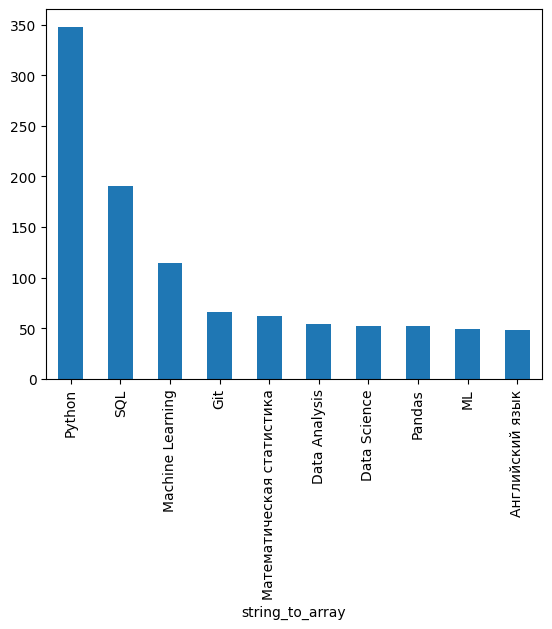

In [72]:
dskils.explode('string_to_array')['string_to_array'].value_counts()[:10].plot.bar()

Итак, чаще всего требуются (выделил жирным более конкретные навыки): 
1. **Python**                      348
2. **SQL**                         191
3. Machine Learning                114
4. **Git**                          66
5. **Математическая статистика**    62
6. Data Analysis                    54
7. Data Science                     52
8. **Pandas**                       52
9. ML                               49
10. **Английский язык**             48

Теперь интересно узнать, у каких категорий по опыту работы  наиболее высокая зарплата.

In [73]:
query_max_salary = f'''
            select
            v.experience, MAX(v.salary_from), MAX(v.salary_to)

            from vacancies v

            WHERE
            (
                   (v.name ILIKE '%data scientist%')
                OR (lower(v.name) ILIKE '%data science%')
                OR (v.name ILIKE '%исследователь данных%')
                OR (v.name  LIKE '%ML%' AND  (v.name NOT iLIKE '%html%'))
                OR (v.name ILIKE '%machine learning%')
                OR (v.name ILIKE '%машинн%обучен%')
                AND (key_skills IS NOT NULL)
            )

            GROUP BY v.experience
            ORDER BY 1
            '''

In [74]:
pd.read_sql(query_max_salary, connection)

,experience,max,max
0,Более 6 лет,NaN,NaN
1,Нет опыта,80000.0,150000.0
2,От 1 года до 3 лет,250000.0,350000.0
3,От 3 до 6 лет,300000.0,700000.0


Рассмотрим, почему в вакансиях с требованием по опыту "Более 6 лет" при группировке выдаётся NaN. Для этого рассмотрим эти вакансии без агрегации

In [75]:
query_salary = f'''
            select
            v.experience, v.salary_from, v.salary_to

            from vacancies v

            WHERE
            (
                   (v.name ILIKE '%data scientist%')
                OR (lower(v.name) ILIKE '%data science%')
                OR (v.name ILIKE '%исследователь данных%')
                OR (v.name  LIKE '%ML%' AND  (v.name NOT iLIKE '%html%'))
                OR (v.name ILIKE '%machine learning%')
                OR (v.name ILIKE '%машинн%обучен%')
                AND (key_skills IS NOT NULL)
            )
            '''

In [110]:
all_ds = pd.read_sql(query_salary, connection)
all_ds.head(3)

,experience,salary_from,salary_to
0,От 1 года до 3 лет,NaN,NaN
1,От 1 года до 3 лет,NaN,NaN
2,От 1 года до 3 лет,50000.0,70000.0


In [111]:
all_ds.dropna().groupby('experience').mean().round()


,salary_from,salary_to
experience,,
Нет опыта,61667.0,116667.0
От 1 года до 3 лет,129474.0,194890.0
От 3 до 6 лет,178275.0,319384.0


In [112]:
# Посмотрим, есть ли хоть одно поле с заполненной зарплатой
all_ds[all_ds['experience']=='Более 6 лет']

,experience,salary_from,salary_to
86,Более 6 лет,NaN,NaN
87,Более 6 лет,NaN,NaN
88,Более 6 лет,NaN,NaN
89,Более 6 лет,NaN,NaN
90,Более 6 лет,NaN,NaN
91,Более 6 лет,NaN,NaN
92,Более 6 лет,NaN,NaN
93,Более 6 лет,NaN,NaN
94,Более 6 лет,NaN,NaN
95,Более 6 лет,NaN,NaN


Результат проверки: ни в одной вакансии по DS с опытом "Более 6 лет" зарплата не указана

---

# Общий вывод по проекту

В предварительном анализе данных:   
1.  Среди работадателей присутствуют большие компании
2.  В БД представлены не только российские вакансии. Кроме того, регионы из табл. areas это не только регионы, но и страны, а также города. Поэтому  насчёт некоторых регионов создаётся необъективная картина: в России не представлено вакансий, но на самом деле в её регионах и городах есть вакансии.

---

В детальном анализе вакансий:   
1. Больше всего вакансий в столице РФ, крупных российских городах и столицах других стран.
2. Поле с зарплатой заполнено в половине вакансий - это довольно мало.
3. Средняя ЗП исходя из зарплатной вилки немного выше чем средняя ЗП по России. Скорее всего из-за иностранных вакансий.
4.  Чаще всего требуется тип трудоустройства - "полная занятость" и тип рабочего графика - "полный день работы".
5. Реже всего требуются сотрудники с опытом более 6 лет; чаще всего - с опытом от 1-го года до 3-х лет.

Полезные выводы для нас (студентов SkillFactory): легче всего искать работу в крупном городе, предполагающую полный день работы и полную занятость и если у вас стаж от 1-го до 3-х лет по данной специальности.

---

В анализе работодателей:
1. Первые 5 мест по количеству публикуемых вакансий занимают работадатели: Яндекс (1933), Ростелеком (491), Тинькофф (444),СБЕР (428), Газпром нефть (331). При чём Яндекс по количеству вакансий значительно превышает другие компании.
2. Среди регионов, в которых нет вакансий, в России наибольшее количество работодателей. Как уже было написано, это не совсем объективная картина - в городах и регионах России есть вакансии.
3. По количеству регионов, в которых работадатели размещают вакансии, первые 5 мест занимают те же компании, которые занимают первые места по количеству публикуемых вакансий: Яндекс, Ростелеком, Тинькофф, СБЕР, Газпром нефть.
4. 36% - доля компаний, у которых не указана сфера деятельности.
5. У некоторых компаний указано несколько сфер деятельности, например, 2ГИС
6. Разработка ПО как сфера деятельности указана у 15% работодателей.
7. Вакансий Яндекса в городах-миллионниках 1% из всех вакансий. Несмотря на то, что вакансий у Яндекса намного больше, чем у других компаний, в процентном отношении это немного.  
  
  
Полезные выводы для нас (студентов SkillFactory): в топ-5 по количеству вакансий и по количеству регионов, в которых они публикуются, попадают компании, связанные с информационными технологиями (Газпром нефть также заинтересована в ИТ-специалистах: https://career.gazprom-neft.ru/vacancies/?spec=213,211,207,214,208,216,209,212,215,217,218,210).  
Яндекс публикует наибольшее количество вакансий.  
Разработка ПО указана в 15% вакансий - это немало.  
Опираясь на представленные данные, можно сделать вывод, что у выпускника SkillFactory в любом случае есть большой шанс найти работу.

---

В предметном анализе:  
1. К данным имеет отношение 4% вакансий. 
2. Доля вакансий, подходящих для начинающего дата-сайентиста: 0.1%.
3. 229 вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres.
4. 357 вакансий, у которых в качестве ключевого навыка указан Python.
5. 6 ключевых навыков в среднем указывают в вакансиях для DS.
6. Дата-сайентист с опытом работы от 3 до 6 лет в среднем может рассчитывать на зарплату 243115 руб.  
  
Полезные выводы для нас (студентов SkillFactory): целых 4% вакансий, относящихся к данным, указывает на то, что работа в сфере данных востребована. Начинающему дата-сайентисту без опыта работы нужно найти подходящую вакансию из 0.1% вакансий, проработать 3-6 лет и можно искать новую работу с зарплатой около 240000 (если представить, что спрос на дата-сайентистов за 3-6 лет не изменится и нет инфляции).
  
В любом случае, согласно этим данным, у дата-сайентистов хорошие возможности для трудоустройства и заработка денег.

---

В доп. исследованиях:  
1. Доля вакансий с навыком SQL или postgres:  
1.1 из всех вакансий: 0.47%  
1.2 из ИТ вакансий: 6.45%  
1.3 из вакансий, относящихся к данным: 12.93%  
1.4  из вакансий для дата-сайентиста: 42.72%  
2.  Доля вакансий с навыком Python:  
2.1  из всех вакансий: 0.73%  
2.2  из ИТ вакансий: 10.05%  
2.3  из вакансий, относящихся к данным: 20.16%  
2.4  из вакансий для дата-сайентиста: 66.6%  
2.5  по отношению к вакансиям с навыками SQL или Postgres: 155.9%  
3. Чаще всего дата-сайентисту требуются навыки:  
3.1 Более конкретно сформулированные: Python (348), SQL (191), Git (66), Математическая статистика (62), Pandas (52), Английский язык (48)  
3.2 Менее конкретно сформулированные: Machine Learning (114), Data Analysis (54), Data Science (52), ML (49)  
4. Самая высокая зарплата дата-сайентиста: 	700000 рублей  
5. В вакансиях data science со стажем больше 6 лет вообще не указана зарплата.  

Полезные выводы для нас: Python, SQL/Postgres оказались очень востребованы в вакансиях для дата-сайентистов. Всё, что включено в курс от SkillFactory (Python , SQL, Git и др) оказалось наиболее востребовано в вакансиях. Согласно данным, дата-сайентисту не обязательно самостоятельно пытаться изучать всё что связано с анализом данных чтобы быть универсальным специалистом (напр., Excel, Docker, Linux, язык для анализа данных R, BI-платформы, ETL-инструменты и др.). Можно сконцентрироваться на изучении перечисленных навыков.  
Если стать очень хорошим специалистом можно получать даже 700000 рублей.

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

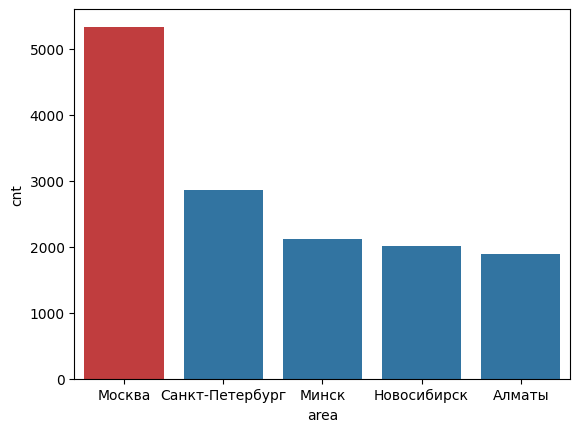

In [114]:
query_4_1 = f'''SELECT a.name area, COUNT(v.area_id) cnt
FROM vacancies v JOIN areas a ON v.area_id = a.id
GROUP BY a.id, a.name
ORDER BY 2 DESC
LIMIT 5
'''
df = pd.read_sql_query(query_4_1, connection)

filtred_color = [('tab:red' if x > 3000 else 'tab:blue') for x in df.cnt]
sns.barplot(df, x='area', y='cnt', palette=filtred_color);

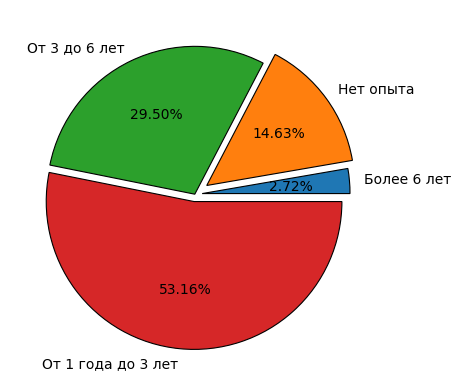

In [115]:
query_4_5 = f'''SELECT experience, COUNT(id)
FROM vacancies
GROUP BY 1
ORDER BY 2
'''
df = pd.read_sql_query(query_4_5, connection)

plt.pie(
    df['count'],
    labels = df['experience'].values,
    autopct = '%.2f%%',
    explode = (0.05, 0.1, 0, 0.05),
    wedgeprops = {'lw':0.8,'edgecolor':'k'},   
);

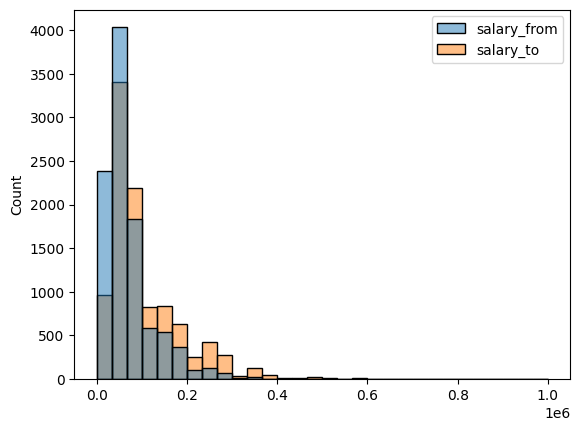

In [116]:
query_4_3 = f'''
SELECT 
    salary_from as salary_from, 
    salary_to as salary_to
FROM 
    vacancies
'''
df = pd.read_sql_query(query_4_3, connection)
df.dropna(inplace=True)
sns.histplot(data=df, bins=30);

In [117]:
# в конце работы закрываем соединение

connection.close()